# Training and testing a simple MLP with Pytorch

## Objectives

- Discover the pytorch framework
- Code a first neural network, train it and test it

We will:

- Define important tools: the networks, the testing and training functions
- Train a perceptron
- Train an MLP with one hidden layer
- Classify the circles dataset

At each step you are encouraged to change parameters to see what works and what does not. 

## 0) Useful things

In the next notebooks this section will become larger as it includes bits of code that have already been covered.

We import python and pytorch packages

In [1]:
import torch
import torch.nn as nn  # the neural network library of pytorch
import torch.nn.functional as F  # functions of the neural network library
import load_dataset as load  # module with function to load data
import numpy as np
import matplotlib.pyplot as plt  # to plot figures
import matplotlib.cm as cm

We load the dataset

In [2]:
batch_size = 1  # the number of examples per batch
train_loader, test_loader, dim_in, dim_out = load.load_circles(batch_size=batch_size, 
                                                               n_samples=1000, shuffle=True, 
                                                               noise=0.1, random_state=None, factor=0.5)

## 1) Defining a neural network with pytorch

We define the network, using pytorch tools. We define our network as a pytorch "Module".

A "Module" needs:
- an "init" function where we define the layers and their parameters
- a "forward" function where we define the information flow through the network

We use 

In [3]:
class MLP(nn.Module): # MLP is of the super class nn.Module
    
    # in the _init_ function we can define attributes of the class.
    # This is also how you can give parameters to your network. Here the input and output dimensions
    def __init__(self, dim_in, dim_hidden, dim_out):
        super(MLP, self).__init__()
        
        # dim_in is the number of inputs
        # dim_hidden is the number of neurons in the hidden layer
        # dim_out is the number of outputs

        # Here we define useful layers
        # here we have two linear layers
        
        # nn.Linear(N, M) defines a layer of vanilla linear synapses of dimensions NxM
        # the layer of synapses has a shape depending the input and output layer sizes
        self.fc1 = nn.Linear(dim_in, dim_hidden)
        self.fc2 = nn.Linear(dim_hidden, dim_out)
        
        # flattens a 2D input (image) into a 1D input (only necessary for MNIST)
        self.flat = nn.Flatten()  


    # This is the function applied when we call the network
    def forward(self, x):
        x = self.flat(x)  # flatten input from 2D (image) to 1D (input vector)
        x = self.fc1(x)  # first fully connected layer of synapses
        x = F.relu(x)  # ReLU neurons of the hidden layer
        x = self.fc2(x)  # second fully connected layer of synapses
        return x  # the output of the network

We create an instance of this perceptron with the correct dimensions.

In [4]:
dim_in = 2
dim_hidden = 10
dim_out = 2
network = MLP(dim_in, dim_hidden, dim_out)

## 2) Training  and testing the neural network

We choose criterion of success, i.e. a specific loss function to compute how our network does. It needs to be thought with the output layer and format of the targets.
The Cross Entropy is a very common choice. It computes the probability of each class. It goes along with the softmax layer at the output.
Go to pytorch to see different loss functions: https://pytorch.org/docs/stable/nn.html#loss-functions

In [5]:
criterion = torch.nn.CrossEntropyLoss()

We choose an optimizer, i.e. specific training algorithm. The most basic one is Stochastic Gradient Descend. ADAM is a more efficient algorithm. 
It takes as input the trainable parameters (i.e. weights) of the network and a learning rate.

Play with the learning rate and see what happens.

Further work: Try training with SGD. Pytorch gives a large number of possible algorithms, updated as the field of machine learning progresses. https://pytorch.org/docs/stable/optim.html 
The original ADAM paper, an example of research in machine learning: https://arxiv.org/abs/1412.6980

In [6]:
learning_rate = 1e-2  # the scale of the changes applied to the weights
optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)  # Adam 
#optimizer = torch.optim.SGD(network.parameters(), lr=learning_rate)  # Stochastic Gradient Descent 

We have defined a function "eval_net()" to evaluate the success of the network. It computes the loss but also gives a prediction: "to which class belongs this image". It computes an accuracy score over all predictions.

In [7]:
def eval_net(network, test_loader, criterion):
    network.eval()  # put in eval mode: we will just run, not modify the network
    test_loss = 0  # initialize the loss
    test_accuracy = 0  # initialize the accuracy

    with torch.no_grad():  # careful, we do not care about gradients here
        # loop on the batches in the test dataset
        for batch_idx, (data, target) in enumerate(test_loader):


            # Run the network and compute the loss
            output = network(data)  # run the network on the test data
            loss = criterion(output, target)  # compare the output to the target and compute the loss, using the chosen loss function
            test_loss += loss.item()  # increment the total test loss

            # Getting the prediction of the network and computing the accuracy
            pred = output.argmax(dim=1, keepdim=True)  # the class chosen by the network is the highest output
            acc = pred.eq(target.view_as(pred)).sum().item()  # the accuracy is the proportion of correct classes
            test_accuracy += acc  # increment accuracy of whole test set

    test_accuracy /= len(test_loader.dataset)  # compute mean accuracy
    test_loss /= (batch_idx + 1)  # mean loss
    return test_loss, test_accuracy

Let's test how the network does before any training. It should be random (so close to 10% for MNIST and Digits, or 50% for Moons and Circles). If not you probably need to restart your notebook.

In [8]:
test_loss, test_accuracy = eval_net(network, test_loader, criterion)
print('Network before training')
print(f'Evaluation on test set: Loss = {test_loss:.6f}, accuracy = {test_accuracy*100:.4f} %')

Network before training
Evaluation on test set: Loss = 0.701655, accuracy = 58.4000 %


We have defined a training function "train_net". Not only does it computes the loss and prediction but also modifies the weights according to the training algorithm. 

In [9]:
def train_net(network, train_loader, criterion, optimizer):    
    network.train()  # put in train mode: we will modify the weights of the network
    train_loss = 0  # initialize the loss
    train_accuracy = 0  # initialize the accuracy

    # loop on the batches in the train dataset
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()  # important step to reset gradients to zero

        # Run the network and compute the loss
        output = network(data)  # we run the network on the data
        loss = criterion(output, target)  # we compare output to the target and compute the loss, using the chosen loss function
        train_loss += loss.item()  # we increment the total train loss

        # !!!Here we do the learning!!!
        loss.backward()  # backpropagation: the gradients are automatically computed by the autograd
        optimizer.step()  # specific optimization rule for changing the weights (stochastic gradient descent, Adam etc)

        # Getting the prediction of the network and computing the accuracy
        pred = output.argmax(dim=1, keepdim=True)  # the class chosen by the network is the highest output
        acc = pred.eq(target.view_as(pred)).sum().item()  # the accuracy is the proportion of correct classes
        train_accuracy += acc  # increment accuracy of whole test set
        
    train_accuracy /= len(train_loader.dataset)  # compute mean accuracy
    train_loss /=  (batch_idx + 1) # mean loss
    return train_loss, train_accuracy

We train the network on the dataset for a few epochs. The training is done on the training set, then we will test the network on the test set. Check that the loss function decreases. It means the training is converging. The accuracy should also go up.

In [10]:
loss_list = []
accuracy_list = []
for epoch in range(100):
    train_loss, train_accuracy = train_net(network, train_loader, criterion, optimizer)
    loss_list.append(train_loss)
    accuracy_list.append(train_accuracy*100)
    
    print(f'Epoch {epoch}: Loss = {train_loss:.6f}, accuracy = {train_accuracy*100:.4f} %')

Epoch 0: Loss = 0.619450, accuracy = 64.1333 %
Epoch 1: Loss = 0.339443, accuracy = 92.5333 %
Epoch 2: Loss = 0.163157, accuracy = 96.6667 %
Epoch 3: Loss = 0.115881, accuracy = 96.4000 %
Epoch 4: Loss = 0.093762, accuracy = 97.7333 %
Epoch 5: Loss = 0.074628, accuracy = 97.7333 %
Epoch 6: Loss = 0.075145, accuracy = 97.2000 %
Epoch 7: Loss = 0.064545, accuracy = 97.7333 %
Epoch 8: Loss = 0.064130, accuracy = 98.1333 %
Epoch 9: Loss = 0.050956, accuracy = 98.6667 %
Epoch 10: Loss = 0.058868, accuracy = 97.7333 %
Epoch 11: Loss = 0.056543, accuracy = 97.8667 %
Epoch 12: Loss = 0.049923, accuracy = 98.1333 %
Epoch 13: Loss = 0.047933, accuracy = 98.0000 %
Epoch 14: Loss = 0.049968, accuracy = 98.2667 %
Epoch 15: Loss = 0.052049, accuracy = 98.0000 %
Epoch 16: Loss = 0.054897, accuracy = 97.7333 %
Epoch 17: Loss = 0.051031, accuracy = 98.1333 %
Epoch 18: Loss = 0.048081, accuracy = 98.6667 %
Epoch 19: Loss = 0.048146, accuracy = 98.4000 %
Epoch 20: Loss = 0.042100, accuracy = 98.5333 %
Ep

Text(0.5, 0.98, 'Training a perceptron')

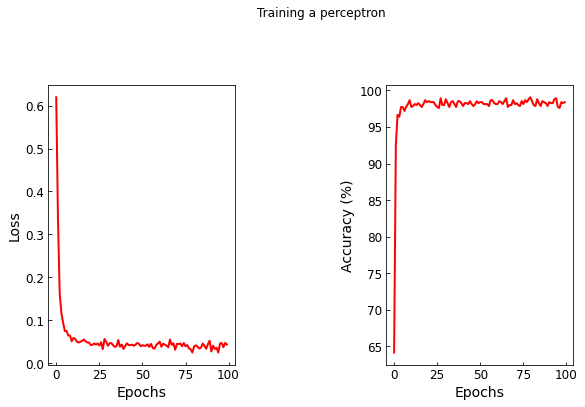

In [11]:
plt.style.use('plot_style.mplstyle')  # A file with parameters on what you want the figure to look like
fig, ax = plt.subplots(1, 2)  # a figure with 1 row and 2 columns of subplots
# fig is the figure itself, ax is an array of two independent subplots inside fig
# on the left side, plot the losses. 
ax[0].plot(loss_list, c='red', ls='-')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
# on the right side, plot the accuracies. 
ax[1].plot(accuracy_list, c='red')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
# We put a title for our figure.
fig_title = f'Training a perceptron'
fig.suptitle(fig_title)

You can save this figure to have a way to compare and remember results

In [12]:
fig.savefig(f'fig_name_with_useful_info.jpeg')

Now we test the network. Typically the accuracy on the test set is lower than on the training set because it has not been trained on this data.

In [13]:
test_loss, test_accuracy = eval_net(network, test_loader, criterion)
print('Network after training')
print(f'Evaluation on test set: Loss = {test_loss:.6f}, accuracy = {test_accuracy*100:.4f} %')

Network after training
Evaluation on test set: Loss = 0.033275, accuracy = 98.8000 %


For the 2D plane classification (moons and circles), we plot the predictions as colors and highlight the misclassified samples

In [14]:
def plot_results(network, x, targets):
    y = network.forward(x)
    p = torch.exp(y)/(torch.exp(y).sum(axis=-1)).unsqueeze(dim=-1)
    pred = y.argmax(dim=1) # the predicted class is the output neurons with the highest value
    idxs = torch.nonzero(((pred == targets[:]) == False)).squeeze() # indexes predicted in wrong class
    x = x.detach().numpy()
    p = p.detach().numpy()
    fig, ax = plt.subplots(1, 2)
    ax[0].scatter(x[:, 0], x[:, 1], c=p[:,1], cmap=cm.coolwarm, vmin=0, vmax=1) # proba to be class 1
    ax[0].set_title('Probability to be class 1')
    ax[1].scatter(x[:, 0], x[:, 1], c=pred, cmap=cm.coolwarm, vmin=0, vmax=1) # class
    ax[1].scatter(x[idxs, 0], x[idxs, 1], facecolors='none', edgecolor='green', linewidths=2) # misclassified
    ax[1].set_title('Predicted class (red = 1)')

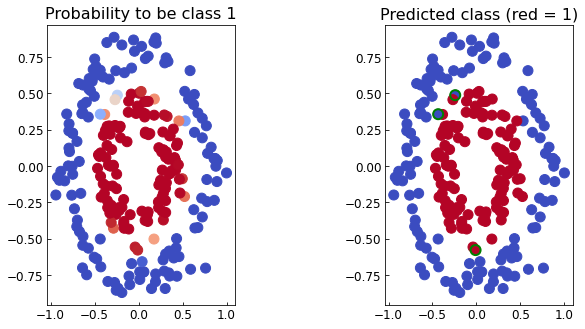

In [15]:
all_X_test = test_loader.dataset.data
all_targets_test = test_loader.dataset.targets
plot_results(network, all_X_test, all_targets_test)